To run this demo, we need to make sure we have the following installed 

    C:\>conda install ipywidgets

and we have to activate nbextension so we can see widget in action

    C:\>jupyter nbextension enable --py widgetsnbextension

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

Let's look at an example of Gaussian filerting, which is convolving the image with a Gaussian Kernel.

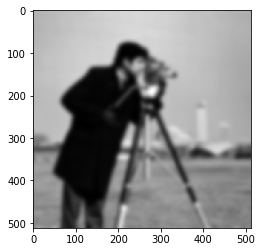

In [2]:
from skimage import data
from skimage import filters
image = data.camera()
smooth_image = filters.gaussian(image, 5)
plt.imshow(smooth_image)

Let's try to generate a Gaussian kernel and see what it looks like.

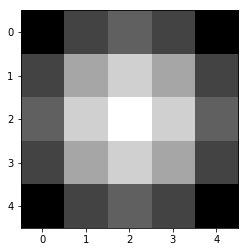

In [3]:
import cv2
gaussian_kernel = cv2.getGaussianKernel(ksize=5, sigma=2)
gaussian_kernel_2d = gaussian_kernel*gaussian_kernel.T
plt.imshow(gaussian_kernel_2d, cmap='gray')

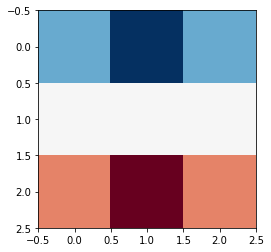

In [4]:
import numpy as np

horizontal_edge_kernel = np.array([[ 1,  2,  1],
                                   [ 0,  0,  0],
                                   [-1, -2, -1]])
# Use non-gray colormap to display negative values as red and positive values as blue.
plt.imshow(horizontal_edge_kernel, cmap=plt.cm.RdBu);

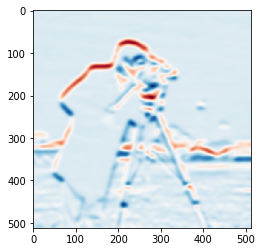

In [5]:
from scipy.ndimage import convolve

horizontal_edge_response = convolve(smooth_image, horizontal_edge_kernel)
plt.imshow(horizontal_edge_response, cmap=plt.cm.RdBu);

In [6]:
def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]

In [7]:
def imshow_pair(image_pair, titles=('', ''), figsize=(10, 5), **kwargs):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    for ax, img, label in zip(axes.ravel(), image_pair, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)

In [8]:
def padding_for_kernel(kernel):
    """ Return the amount of padding needed for each side of an image.

    For example, if the returned result is [1, 2], then this means an
    image should be padded with 1 extra row on top and bottom, and 2
    extra columns on the left and right.
    """
    # Slice to ignore RGB channels if they exist.
    image_shape = kernel.shape[:2]
    # We only handle kernels with odd dimensions so make sure that's true.
    # (The "center" pixel of an even number of pixels is arbitrary.)
    assert all((size % 2) == 1 for size in image_shape)
    return [(size - 1) // 2 for size in image_shape]

In [9]:
def add_padding(image, kernel):
    h_pad, w_pad = padding_for_kernel(kernel)
    return np.pad(image, ((h_pad, h_pad), (w_pad, w_pad)),
                  mode='constant', constant_values=0)

In [10]:
def remove_padding(image, kernel):
    inner_region = []  # A 2D slice for grabbing the inner image region
    for pad in padding_for_kernel(kernel):
        slice_i = slice(None) if pad == 0 else slice(pad, -pad)
        inner_region.append(slice_i)
    return image[inner_region]

In [11]:
image = np.empty((10, 20))
print(image.shape)

(10, 20)


In [12]:
kernel = np.ones((3, 5))
print(kernel.shape)

(3, 5)


In [13]:
padded = add_padding(image, kernel)
print(padded.shape)

(12, 24)


In [14]:
print(remove_padding(padded, kernel).shape)

(10, 20)


In [15]:
def window_slice(center, kernel):
    r, c = center
    r_pad, c_pad = padding_for_kernel(kernel)
    # Slicing is (inclusive, exclusive) so add 1 to the stop value
    return [slice(r-r_pad, r+r_pad+1), slice(c-c_pad, c+c_pad+1)]

In [16]:
image = np.arange(4) + 10 * np.arange(4).reshape(4, 1)
print(image)

[[ 0  1  2  3]
 [10 11 12 13]
 [20 21 22 23]
 [30 31 32 33]]


In [17]:
dummy_kernel = np.empty((3, 3))  # We only care about the shape
center = (1, 1)
print(image[window_slice(center, dummy_kernel)])

[[ 0  1  2]
 [10 11 12]
 [20 21 22]]


In [18]:
print(image[window_slice((1, 2), dummy_kernel)])

[[ 1  2  3]
 [11 12 13]
 [21 22 23]]


In [19]:
print(image[window_slice((2, 1), dummy_kernel)])

[[10 11 12]
 [20 21 22]
 [30 31 32]]


In [20]:
dummy_kernel = np.empty((3, 1))
print(image[window_slice((2, 1), dummy_kernel)])

[[11]
 [21]
 [31]]


In [21]:
def apply_kernel(center, kernel, original_image):
    image_patch = original_image[window_slice(center, kernel)]
    # An element-wise multiplication followed by the sum
    return np.sum(kernel * image_patch)

In [22]:
def iter_kernel_labels(image, kernel):
    """ Yield position and kernel labels for each pixel in the image.

    The kernel label-image has a 2 at the center and 1 for every other
    pixel "under" the kernel. Pixels not under the kernel are labeled as 0.

    Note that the mask is the same size as the input image.
    """
    original_image = image
    image = add_padding(original_image, kernel)
    i_pad, j_pad = padding_for_kernel(kernel)

    for (i, j), pixel in iter_pixels(original_image):
        # Shift the center of the kernel to ignore padded border.
        i += i_pad
        j += j_pad
        mask = np.zeros(image.shape, dtype=int)  # Background = 0
        mask[window_slice((i, j), kernel)] = 1   # Kernel = 1
        mask[i, j] = 2                           # Kernel-center = 2
        yield (i, j), mask

In [23]:
from skimage import color

def visualize_kernel(kernel_labels, image):
    """ Return a composite image, where 1's are yellow and 2's are red.

    See `iter_kernel_labels` for info on the meaning of 1 and 2.
    """
    return color.label2rgb(kernel_labels, image, bg_label=0,
                           colors=('yellow', 'red'))

In [24]:
from ipywidgets import interact

def printer(i):
    print("i = {}".format(i))

# This should be executed in an IPython notebook!
interact(printer, i=(0, 10));

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',))

In [25]:
def make_convolution_step_function(image, kernel, **kwargs):
    # Initialize generator since we're only ever going to iterate over
    # a pixel once. The cached result is used, if we step back.
    gen_kernel_labels = iter_kernel_labels(image, kernel)

    image_cache = []
    image = add_padding(image, kernel)

    def convolution_step(i_step):
        """ Plot original image and kernel-overlay next to filtered image.

        For a given step, check if it's in the image cache. If not
        calculate all necessary images, then plot the requested step.
        """

        # Create all images up to the current step, unless they're already
        # cached:
        while i_step >= len(image_cache):

            # For the first step (`i_step == 0`), the original image is the
            # filtered image; after that we look in the cache, which stores
            # (`kernel_overlay`, `filtered`).
            filtered_prev = image if i_step == 0 else image_cache[-1][1]
            # We don't want to overwrite the previously filtered image:
            filtered = filtered_prev.copy()

            # Get the labels used to visualize the kernel
            center, kernel_labels = next(gen_kernel_labels)
            # Modify the pixel value at the kernel center
            filtered[center] = apply_kernel(center, kernel, image)
            # Take the original image and overlay our kernel visualization
            kernel_overlay = visualize_kernel(kernel_labels, image)
            # Save images for reuse.
            image_cache.append((kernel_overlay, filtered))

        # Remove padding we added to deal with boundary conditions
        # (Loop since each step has 2 images)
        image_pair = [remove_padding(each, kernel)
                      for each in image_cache[i_step]]
        imshow_pair(image_pair, **kwargs)
        plt.show()

    return convolution_step  # <-- this is a function

In [26]:
from ipywidgets import IntSlider
import ipywidgets as widgets
def interactive_convolution_demo(image, kernel, **kwargs):
    stepper = make_convolution_step_function(image, kernel, **kwargs)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    widgets.interact(stepper, i_step=step_slider)

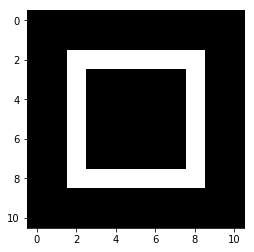

In [27]:
import numpy as np
bright_square = np.zeros((11, 11), dtype=float)
bright_square[2:9, 2:9] = 1
bright_square[3:8, 3:8] = 0
plt.imshow(bright_square);

In [28]:
mean_kernel = np.ones((3, 3), dtype=float)
mean_kernel /= mean_kernel.size
print(mean_kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


In [29]:
titles = ('Image and kernel', 'Filtered image')
interactive_convolution_demo(bright_square, mean_kernel,
                             vmax=1, titles=titles)

interactive(children=(IntSlider(value=0, description='i_step', max=120), Output()), _dom_classes=('widget-interact',))

In [30]:
gaussian_kernel = cv2.getGaussianKernel(ksize=3, sigma=1)
gaussian_kernel_2d = gaussian_kernel*gaussian_kernel.T
titles = ('Image and kernel', 'Filtered image')
interactive_convolution_demo(bright_square, gaussian_kernel_2d,
                             vmax=1, titles=titles)

interactive(children=(IntSlider(value=0, description='i_step', max=120), Output()), _dom_classes=('widget-interact',))

In [31]:
titles = ('Image and kernel', 'Filtered image')
interactive_convolution_demo(bright_square, horizontal_edge_kernel,
                             vmax=1, titles=titles)

interactive(children=(IntSlider(value=0, description='i_step', max=120), Output()), _dom_classes=('widget-interact',))